## Random Forest: Valutazione dell'Iperparametro `n_estimators`

In questa sezione analizziamo il comportamento del classificatore **Random Forest**, focalizzandoci sull'effetto dell'iperparametro `n_estimators`, che rappresenta il **numero di alberi nella foresta**.

Per ciascun valore di `n_estimators`:
- Applichiamo una **10-fold cross-validation**.
- Valutiamo le metriche: `accuracy`, `precision (macro)`, `recall (macro)` e `f1-score (macro)`.
- Tracciamo l'**errore medio (1 - metrica)** al variare di `n_estimators`, con intervalli di deviazione standard.

L'obiettivo è:
- **Scegliere il numero ottimale di alberi** in base al `f1-score macro`.
- Osservare la **stabilità del modello** al variare della complessità.


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

In [3]:
TRAINING_PATH = "risorse/training_bilanciato.csv"
TEST_PATH     = "risorse/test_set.csv"
FEATURES = ["OFF_FISICO", "OFF_SPECIALE", "TANK_FISICO", "TANK_SPECIALE"]
TARGET   = "Archetipo"

df_train = pd.read_csv(TRAINING_PATH)
df_test  = pd.read_csv(TEST_PATH)

# Controllo colonne
missing_train = [c for c in FEATURES + [TARGET] if c not in df_train.columns]
missing_test  = [c for c in FEATURES + [TARGET] if c not in df_test.columns]
if missing_train:
    raise KeyError(f"Mancano colonne nel TRAINING SET: {missing_train}")
if missing_test:
    raise KeyError(f"Mancano colonne nel TEST SET: {missing_test}")

# Selezione e copia
df_train = df_train[FEATURES + [TARGET]].copy()
df_test  = df_test[FEATURES + [TARGET]].copy()

# Conversione a numerico
for c in FEATURES:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce")
    df_test[c]  = pd.to_numeric(df_test[c],  errors="coerce")

# Drop NaN (train e test)
before = len(df_train)
df_train = df_train.dropna(subset=FEATURES + [TARGET])
after = len(df_train)
if after < before:
    print(f"Attenzione: rimosse {before - after} righe (NaN) dal TRAINING.")

before_t = len(df_test)
df_test  = df_test.dropna(subset=FEATURES + [TARGET])
after_t  = len(df_test)
if after_t < before_t:
    print(f"Attenzione: rimosse {before_t - after_t} righe (NaN) dal TEST.")

# Distribuzioni classi
print("Distribuzione classi del TRAINING SET (y_train):")
x_train = df_train[FEATURES].values
y_train = df_train[TARGET].values
print(pd.Series(y_train).value_counts(normalize=True).round(2))
print(pd.Series(y_train).value_counts())

print("\nDistribuzione classi del TEST SET (y_test):")
x_test = df_test[FEATURES].values
y_test = df_test[TARGET].values
print(pd.Series(y_test).value_counts(normalize=True).round(2))
print(pd.Series(y_test).value_counts())

Distribuzione classi del TRAINING SET (y_train):
Balanced             0.25
Attaccante           0.25
Tank                 0.25
Elite/Leggendario    0.25
Name: proportion, dtype: float64
Balanced             245
Attaccante           245
Tank                 245
Elite/Leggendario    245
Name: count, dtype: int64

Distribuzione classi del TEST SET (y_test):
Attaccante           0.36
Balanced             0.31
Tank                 0.22
Elite/Leggendario    0.11
Name: proportion, dtype: float64
Attaccante           54
Balanced             47
Tank                 33
Elite/Leggendario    17
Name: count, dtype: int64


In [4]:
# Dizionario delle metriche da usare in cross-validation
scoring = {
    "accuracy": "accuracy",
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# === [2] Valori da testare per il numero di alberi ===
n_estimators_values = [10, 25, 50, 75, 100, 150, 200]

# Lista per salvare i risultati
results = []

# === Cross-validation per ciascun valore di n_estimators ===
for n in n_estimators_values:
    #print(f"Valutazione per n_estimators = {n}...")

    # Inizializza il classificatore Random Forest
    clf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)

    # 10-fold Stratified Cross-Validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_result = cross_validate(clf, x_train, y_train, cv=cv, scoring=scoring)

    # Aggiungi le metriche medie e deviazioni standard
    results.append({
        "n_estimators": n,
        "accuracy_mean": np.mean(cv_result["test_accuracy"]),
        "accuracy_std":  np.std(cv_result["test_accuracy"]),
        "precision_mean": np.mean(cv_result["test_precision_macro"]),
        "precision_std":  np.std(cv_result["test_precision_macro"]),
        "recall_mean":    np.mean(cv_result["test_recall_macro"]),
        "recall_std":     np.std(cv_result["test_recall_macro"]),
        "f1_mean":        np.mean(cv_result["test_f1_macro"]),
        "f1_std":         np.std(cv_result["test_f1_macro"]),
    })

# Converti i risultati in un DataFrame
df_results = pd.DataFrame(results)
# Arrotonda e visualizza le metriche ottenute per ogni valore di n_estimators
display(df_results.round(4))
# === [4] Media complessiva e deviazione standard tra i diversi n_estimators ===
summary_overall = pd.DataFrame({
    "media": [
        df_results["accuracy_mean"].mean(),
        df_results["precision_mean"].mean(),
        df_results["recall_mean"].mean(),
        df_results["f1_mean"].mean(),
    ],
    "dev_std": [
        df_results["accuracy_mean"].std(),
        df_results["precision_mean"].std(),
        df_results["recall_mean"].std(),
        df_results["f1_mean"].std(),
    ]
}, index=["Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"])

# Visualizzazione
print("=== Media ± Deviazione Std delle metriche su tutti i n_estimators ===")
display(summary_overall.round(4))

,n_estimators,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,10,0.9612,0.0170,0.9633,0.0159,0.9612,0.0169,0.9613,0.0168
1,25,0.9673,0.0170,0.9690,0.0160,0.9673,0.0169,0.9673,0.0169
2,50,0.9684,0.0161,0.9699,0.0152,0.9685,0.0160,0.9685,0.0159
3,75,0.9684,0.0148,0.9697,0.0139,0.9685,0.0147,0.9684,0.0146
4,100,0.9694,0.0188,0.9711,0.0173,0.9694,0.0189,0.9694,0.0190
5,150,0.9673,0.0163,0.9692,0.0148,0.9673,0.0165,0.9673,0.0165
6,200,0.9673,0.0150,0.9691,0.0137,0.9674,0.0150,0.9674,0.0150


=== Media ± Deviazione Std delle metriche su tutti i n_estimators ===


,media,dev_std
Accuracy,0.9671,0.0027
Precision (macro),0.9688,0.0025
Recall (macro),0.9671,0.0027
F1-score (macro),0.9671,0.0027


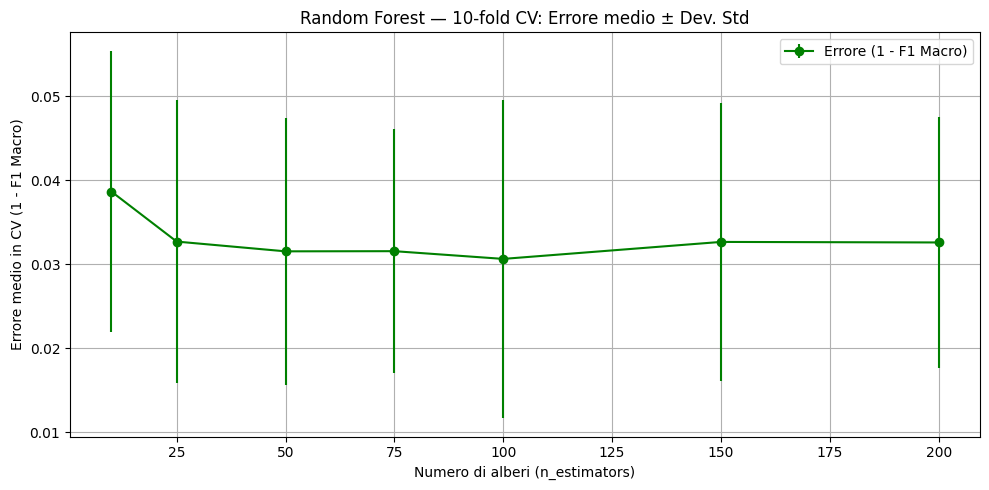

In [5]:
# === Plot: 1 - F1-score (errore) al variare di n_estimators ===

plt.figure(figsize=(10, 5))
plt.errorbar(df_results["n_estimators"], 1 - df_results["f1_mean"],
             yerr=df_results["f1_std"], fmt='-o', color='green',
             label="Errore (1 - F1 Macro)")

plt.xlabel("Numero di alberi (n_estimators)")
plt.ylabel("Errore medio in CV (1 - F1 Macro)")
plt.title("Random Forest — 10-fold CV: Errore medio ± Dev. Std")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# === Selezione del miglior n_estimators ===

# Trova il numero di alberi che massimizza la F1 macro
# best_n = df_results.sort_values("f1_mean", ascending=False).iloc[0]["n_estimators"]
best_n = 75
print(f"Valore di n_estimators scelto: {int(best_n)}")

Valore di n_estimators scelto: 75


=== Performance su test set ===
Accuracy: 0.9470
Precision_macro: 0.9498
Recall_macro: 0.9232
F1_macro: 0.9350


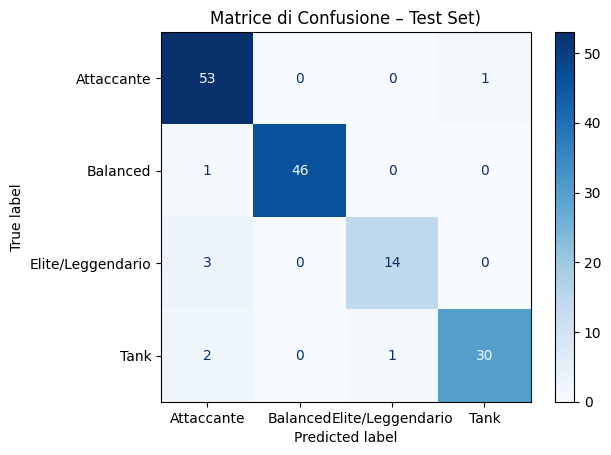

In [7]:
# === Addestramento finale su tutto il training set e valutazione sul test ===

# Istanziamo il modello con il miglior numero di alberi
final_rf = RandomForestClassifier(n_estimators=int(best_n), random_state=42)
final_rf.fit(x_train, y_train)

# Predizione sul test set
y_pred = final_rf.predict(x_test)

# Calcolo delle metriche
final_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0)
}

# Visualizzazione delle metriche
print("=== Performance su test set ===")
for metrica, valore in final_metrics.items():
    print(f"{metrica.capitalize()}: {valore:.4f}")

# Matrice di confusione
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    cmap="Blues",
    normalize=None
)
plt.title(f"Matrice di Confusione – Test Set)")
plt.grid(False)
plt.show()

=== Importanza delle feature (valori numerici) ===


,Feature,Importanza
0,OFF_FISICO,0.2659
1,OFF_SPECIALE,0.2650
2,TANK_FISICO,0.2362
3,TANK_SPECIALE,0.2329


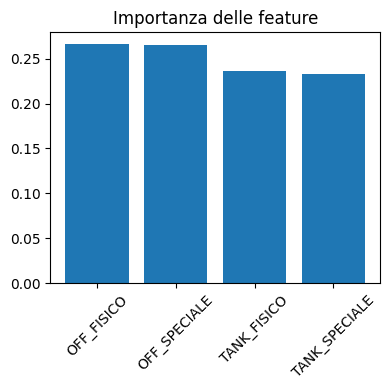

In [8]:
# === [Importanza delle feature - Tabella + Grafico] ===

# Calcolo delle importanze
feature_importances = final_rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Nomi delle feature ordinate per importanza
feature_names_ordered = [FEATURES[i] for i in indices]

# Creazione DataFrame ordinato
df_importanza = pd.DataFrame({
    "Feature": feature_names_ordered,
    "Importanza": feature_importances[indices]
})

# Visualizzazione tabellare
print("=== Importanza delle feature (valori numerici) ===")
display(df_importanza.round(4))

# Visualizzazione grafica
plt.figure(figsize=(4, 4))
plt.title("Importanza delle feature")
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), feature_names_ordered, rotation=45)
plt.tight_layout()
plt.show()


#### Confronto dell'importanza delle feature: Random Forest vs Decision Tree

L'importanza delle feature ci permette di capire quali variabili sono maggiormente utilizzate dal modello per prendere decisioni.

- Nel caso della **Random Forest**, l'importanza risulta **più bilanciata** tra tutte le feature (`OFF_FISICO`, `OFF_SPECIALE`, `TANK_FISICO`, `TANK_SPECIALE`).
  - Questo comportamento è atteso: essendo un ensemble di molti alberi, la Random Forest **riduce la varianza** e **distribuisce il peso decisionale** tra più feature.
  - È indice di una **maggiore generalizzazione** del modello.

- Nel caso dell’**albero di decisione singolo**, si osserva una forte predominanza della feature `OFF_FISICO`, che supera da sola il **35%** dell'importanza totale.
  - Questo indica che l'albero tende a **fare split molto precoci** su questa feature, portando potenzialmente a **overfitting**.
  - Le altre feature risultano decisamente meno considerate.

### Conclusione
- La Random Forest non solo ha **prestazioni migliori**, ma è anche **più robusta e meno sbilanciata** nell'uso delle feature.
- Questo la rende preferibile per problemi in cui è importante evitare che una singola variabile domini il processo decisionale.
